# Analyzing Video Metadata

### Part 1: Analyzing Tags
- tag vs number of videos: most videos, least videos
- tag vs duration: most duration, least duration, average duration

### Part 2: Analyzing Categories

#### Topic Modelling 
- Unsupervised Topic Clustering to figure out which tags belong together. 
- Assigning an appropriate category manually.
- Assigning Categories to each video based on it's tags list

#### Category analysis
- category vs number of videos: most videos, least videos
- category vs duration: most duration, least duration, average duration

---

## Imports

In [1]:
import numpy as np
import pandas as pd
import isodate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

---

## Reading and Understanding the Data

In [2]:
df = pd.read_json('video_relevant_data.json', orient='index')

In [3]:
df.head(5)

,id,publishedAt,tags,categoryId,duration,viewCount,likeCount,commentCount,topicCategories
gOR9qZ3ZgwA,gOR9qZ3ZgwA,2020-07-15T13:00:14Z,"[Víctor Robles, Victor Robles WEB, victorroble...",27,PT19M48S,436665,16089,422,[https://en.wikipedia.org/wiki/Knowledge]
rC7X3nCwdZ8,rC7X3nCwdZ8,2019-05-14T22:00:04Z,"[votw, froglogic, squish, gui testing, gui aut...",28,PT3M57S,5067,14,3,[https://en.wikipedia.org/wiki/Knowledge]
WTLPmUHTPqo,WTLPmUHTPqo,2022-02-20T16:00:14Z,"[tech with tim, planet simulation in python, h...",27,PT1H2S,84771,3567,186,[https://en.wikipedia.org/wiki/Knowledge]
RjhiMjY1nI0,RjhiMjY1nI0,2021-06-18T12:00:10Z,"[python tutorial ita, tutorial python ita, tut...",27,PT9M28S,9726,250,64,[https://en.wikipedia.org/wiki/Knowledge]
YJyIykLyOmo,YJyIykLyOmo,2020-05-08T15:14:00Z,"[python bank management system project, python...",27,PT8M54S,2285,43,6,[https://en.wikipedia.org/wiki/Knowledge]


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 458 entries, gOR9qZ3ZgwA to Y8Tko2YC5hA
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               458 non-null    object
 1   publishedAt      458 non-null    object
 2   tags             458 non-null    object
 3   categoryId       458 non-null    int64 
 4   duration         458 non-null    object
 5   viewCount        458 non-null    int64 
 6   likeCount        458 non-null    int64 
 7   commentCount     458 non-null    int64 
 8   topicCategories  458 non-null    object
dtypes: int64(4), object(5)
memory usage: 35.8+ KB


In [5]:
df.describe()

,categoryId,viewCount,likeCount,commentCount
count,458.000000,4.580000e+02,458.000000,458.000000
mean,24.707424,1.798409e+06,24443.908297,1317.021834
std,5.705154,7.613505e+06,70015.406159,5300.866314
min,1.000000,1.000000e+00,0.000000,0.000000
25%,26.000000,1.693025e+04,421.250000,37.000000
50%,27.000000,1.062635e+05,3614.500000,171.000000
75%,27.000000,8.252188e+05,20034.000000,847.500000
max,28.000000,1.282673e+08,778630.000000,84449.000000


In [6]:
df.shape

(458, 9)

### Data Preprocessing

In [7]:
# converting duration and publishedAt to datetime
df['duration'] = df['duration'].apply(lambda x: isodate.parse_duration(x))
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

In [8]:
# dropping id column as index already has that value
df.drop('id', axis=1, inplace=True)

In [9]:
df.head(2)

,publishedAt,tags,categoryId,duration,viewCount,likeCount,commentCount,topicCategories
gOR9qZ3ZgwA,2020-07-15 13:00:14+00:00,"[Víctor Robles, Victor Robles WEB, victorroble...",27,0 days 00:19:48,436665,16089,422,[https://en.wikipedia.org/wiki/Knowledge]
rC7X3nCwdZ8,2019-05-14 22:00:04+00:00,"[votw, froglogic, squish, gui testing, gui aut...",28,0 days 00:03:57,5067,14,3,[https://en.wikipedia.org/wiki/Knowledge]


In [10]:
# fetching complete list of unique tags from tags column
all_tags = list(set(",".join(df['tags'].apply(lambda x: ",".join(x)).to_list()).split(",")))

In [11]:
len(all_tags)

5695

In [12]:
print(all_tags[0:10])

['lodges', 'milk production', 'Rocka', 'cybersecurity using python', 'efteling achtbaan', 'okunaklık', 'dataset', 'manuale pygame italiano', 'history channel documentaries', 'catching pythons in florida']


In [13]:
# creating seperate column for each unique tag for further analysis
for tag in all_tags:
    df[tag] = df['tags'].apply(lambda x: tag in x).map(int)

In [14]:
df.shape

(458, 5703)

In [15]:
df.head(1)

,publishedAt,tags,categoryId,duration,viewCount,likeCount,commentCount,topicCategories,lodges,milk production,...,farm,TUPLES,latest sighting,openpyxl tutorial,elif,desde,addition,Coding,Features of python,Down Under
gOR9qZ3ZgwA,2020-07-15 13:00:14+00:00,"[Víctor Robles, Victor Robles WEB, victorroble...",27,0 days 00:19:48,436665,16089,422,[https://en.wikipedia.org/wiki/Knowledge],0,0,...,0,0,0,0,0,0,0,0,0,0


---

### Analyzing tags

#### Video Count
- tag vs video count
- tag with most videos
- tag with least videos

In [16]:
tag_vs_vid_count_df = pd.DataFrame(df.iloc[:, 8:].sum().sort_values(ascending=False), columns=["total_vid_count"])

In [17]:
tag_vs_vid_count_df.head(2)

,total_vid_count
python,199
python tutorial,80


In [18]:
tag_vs_vid_count_df.tail(2)

,total_vid_count
parallel,1
Down Under,1


In [19]:
tag_vs_vid_count_df.to_csv('tags_vs_video_count.csv', index_label=['Tag'])

In [20]:
# tags with max videos
tag_vs_vid_count_df[tag_vs_vid_count_df['total_vid_count'] == tag_vs_vid_count_df['total_vid_count'].max()]

,total_vid_count
python,199


In [21]:
# tags with min videos
tag_vs_vid_count_df[tag_vs_vid_count_df['total_vid_count'] == tag_vs_vid_count_df['total_vid_count'].min()]

,total_vid_count
frill necked lizard running,1
double,1
learn pandas dataframe,1
rest apis,1
programming fundamentals,1
...,...
astronomy programming,1
hyena vs python vs impala,1
coding courses for beginners free,1
parallel,1


---

#### Duration
- tag vs duration
- tag with most duration
- tag with least duration
- average duration for each tag

In [22]:
tag_vs_duration = {}

for column in df.iloc[:, 8:]:
    average_duration = df[df[column] == 1]['duration'].sum()/len(df[df[column] == 1])
    total_duration_for_tag = df[df[column] == 1]['duration'].sum()
    tag_vs_duration[column] = [average_duration, total_duration_for_tag]

tag_vs_duration_df = pd.DataFrame.from_dict(tag_vs_duration, orient='index', columns=['avg_duration', 'total_duration'])

In [23]:
tag_vs_duration_df.head(1)

,avg_duration,total_duration
lodges,0 days 00:06:49,0 days 00:06:49


In [24]:
tag_vs_count_duration_df = tag_vs_vid_count_df.join(tag_vs_duration_df)

In [25]:
tag_vs_count_duration_df.head(2)

,total_vid_count,avg_duration,total_duration
python,199,0 days 01:06:50.080402010,9 days 05:40:06
python tutorial,80,0 days 02:01:50.025000,6 days 18:26:42


In [26]:
# max total duration
tag_vs_duration_df[tag_vs_duration_df['total_duration'] == tag_vs_duration_df['total_duration'].max()]

,avg_duration,total_duration
python,0 days 01:06:50.080402010,9 days 05:40:06


In [27]:
# min total duration
tag_vs_duration_df[tag_vs_duration_df['total_duration'] == tag_vs_duration_df['total_duration'].min()]

,avg_duration,total_duration
Monty Python And The Holy Grail,0 days 00:00:10,0 days 00:00:10
leaf media,0 days 00:00:10,0 days 00:00:10


In [28]:
# max average duration
tag_vs_duration_df[tag_vs_duration_df['avg_duration'] == tag_vs_duration_df['avg_duration'].max()]

,avg_duration,total_duration
university of michigan,0 days 13:40:10,0 days 13:40:10
py4e,0 days 13:40:10,0 days 13:40:10
u of m,0 days 13:40:10,0 days 13:40:10
charles severance,0 days 13:40:10,0 days 13:40:10
python tutorial 2019,0 days 13:40:10,0 days 13:40:10
dr. chuck,0 days 13:40:10,0 days 13:40:10
dr chuck,0 days 13:40:10,0 days 13:40:10


In [29]:
# min average duration
tag_vs_duration_df[tag_vs_duration_df['avg_duration'] == tag_vs_duration_df['avg_duration'].min()]

,avg_duration,total_duration
Monty Python And The Holy Grail,0 days 00:00:10,0 days 00:00:10
leaf media,0 days 00:00:10,0 days 00:00:10


#### Storing Tag vs Count & Duration Information in csv file

In [30]:
tag_vs_count_duration_df.to_csv('tag_analysis.csv', index_label=['Tag'])

---

### Category Analysis

#### Topic Modelling
- To group tags into categories we need to perform topic modelling i.e. unsupervised clustering of tags
- Then we need to manually assign relevant categories to topics

In [31]:
# converting list to string for topic modelling
df["tags_str"] = df['tags'].apply(lambda x: " ".join(x))

In [32]:
vect = TfidfVectorizer(stop_words='english')
X = vect.fit_transform(df["tags_str"])

pd.DataFrame(X.toarray(), columns=vect.get_feature_names())[0:10]

,10,100,1000,1000iqgameplays,100本ノック,1080p,11,12,15,16,...,코딩독학,코딩테스트,크롤링,테스트,파이썬,파이썬강의,파이썬강좌,파이썬공부,파이썬독학,프로그래밍
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222185,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# choosing 5 as the number of topics (clusters)
N_TOPICS = 8
nmf = NMF(n_components=N_TOPICS, init='nndsvd')
W = nmf.fit_transform(X)  # Document-topic matrix
H = nmf.components_       # Topic-term matrix

In [34]:
NUM_TOP_WORDS_TO_SHOW = 10
words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, NUM_TOP_WORDS_TO_SHOW)), 
                           index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(NUM_TOP_WORDS_TO_SHOW)]
                          ).astype(str)

for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:NUM_TOP_WORDS_TO_SHOW]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,python,programming,learn,tutorial,beginners,course,language,development,coding,software
Topic 2,python,curso,tutorial,windows,programacion,install,aprender,corso,em,en
Topic 3,telusko,navin,reddy,java,tutorial,set,python,robotics,google,ai
Topic 4,movie,snake,adventure,free,chinese,king,action,movies,horror,youku
Topic 5,data,learning,science,machine,pandas,analysis,intelligence,artificial,python,numpy
Topic 6,hindi,python,tutorial,beginners,learn,course,complete,video,class,pandas
Topic 7,для,уроки,питон,нуля,начинающих,программирование,python,пайтон,как,pygame
Topic 8,animals,snake,animal,national,wild,wildlife,geographic,nat,geo,vs


In [35]:
# assigning topics
topic_mapping = {
    'Topic 1': 'python tutorials for beginners',
    'Topic 2': 'python tutorials (non-en)',
    'Topic 3': 'general purpose programming',
    'Topic 4': 'movies',
    'Topic 5': 'machine learning and ai',
    'Topic 6': 'python tutorials in hindi',
    'Topic 7': 'python tutorials in russian',
    'Topic 8': 'wildlife'
}

In [36]:
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(N_TOPICS)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
W[pd.notnull(W['max_topic'])].head(2)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,max_topic
0,0.00000,0.298143,0.003912,0.000000,0.0,0.00000,0.0,0.0,python tutorials (non-en)
1,0.02652,0.040989,0.017943,0.009154,0.0,0.00366,0.0,0.0,python tutorials (non-en)


In [37]:
df['category'] = W['max_topic'].to_list()

In [38]:
df.head(2)

,publishedAt,tags,categoryId,duration,viewCount,likeCount,commentCount,topicCategories,lodges,milk production,...,latest sighting,openpyxl tutorial,elif,desde,addition,Coding,Features of python,Down Under,tags_str,category
gOR9qZ3ZgwA,2020-07-15 13:00:14+00:00,"[Víctor Robles, Victor Robles WEB, victorroble...",27,0 days 00:19:48,436665,16089,422,[https://en.wikipedia.org/wiki/Knowledge],0,0,...,0,0,0,0,0,0,0,0,Víctor Robles Victor Robles WEB victorrobleswe...,python tutorials (non-en)
rC7X3nCwdZ8,2019-05-14 22:00:04+00:00,"[votw, froglogic, squish, gui testing, gui aut...",28,0 days 00:03:57,5067,14,3,[https://en.wikipedia.org/wiki/Knowledge],0,0,...,0,0,0,0,0,0,0,0,votw froglogic squish gui testing gui automati...,python tutorials (non-en)


#### Analyzing Categories
- category vs total videos
- category vs duration

In [39]:
category_df = pd.DataFrame(df['category'].value_counts())
category_df

,category
python tutorials (non-en),197
python tutorials for beginners,73
wildlife,62
machine learning and ai,40
python tutorials in russian,33
python tutorials in hindi,20
general purpose programming,18
movies,15


In [40]:
# Most Popular Category
category_df[category_df.category == category_df.category.max()]

,category
python tutorials (non-en),197


In [41]:
# Least Popular Category
category_df[category_df.category == category_df.category.min()]

,category
movies,15


In [42]:
total_duration_cat_df = pd.DataFrame(df.groupby('category')['duration'].sum())
total_duration_cat_df

,duration
category,
general purpose programming,1 days 02:24:26
machine learning and ai,2 days 10:26:33
movies,0 days 09:24:00
python tutorials (non-en),6 days 07:49:27
python tutorials for beginners,4 days 23:13:41
python tutorials in hindi,2 days 03:56:35
python tutorials in russian,0 days 23:22:28
wildlife,0 days 09:17:49


In [43]:
avg_duration_cat_df = pd.DataFrame(df.groupby('category')['duration'].sum().sort_values(ascending=False)/df['category'].value_counts(), columns=['avg_duration'])
avg_duration_cat_df

,avg_duration
general purpose programming,0 days 01:28:01.444444444
machine learning and ai,0 days 01:27:39.825000
movies,0 days 00:37:36
python tutorials (non-en),0 days 00:46:14.451776649
python tutorials for beginners,0 days 01:37:59.739726027
python tutorials in hindi,0 days 02:35:49.750000
python tutorials in russian,0 days 00:42:29.939393939
wildlife,0 days 00:08:59.822580645


In [44]:
category_vs_duration_df = total_duration_cat_df.join(avg_duration_cat_df).sort_values(by='avg_duration', ascending=False)
category_vs_duration_df

,duration,avg_duration
category,,
python tutorials in hindi,2 days 03:56:35,0 days 02:35:49.750000
python tutorials for beginners,4 days 23:13:41,0 days 01:37:59.739726027
general purpose programming,1 days 02:24:26,0 days 01:28:01.444444444
machine learning and ai,2 days 10:26:33,0 days 01:27:39.825000
python tutorials (non-en),6 days 07:49:27,0 days 00:46:14.451776649
python tutorials in russian,0 days 23:22:28,0 days 00:42:29.939393939
movies,0 days 09:24:00,0 days 00:37:36
wildlife,0 days 09:17:49,0 days 00:08:59.822580645


In [45]:
category_vs_duration_df.to_csv("category_analysis.csv")

---

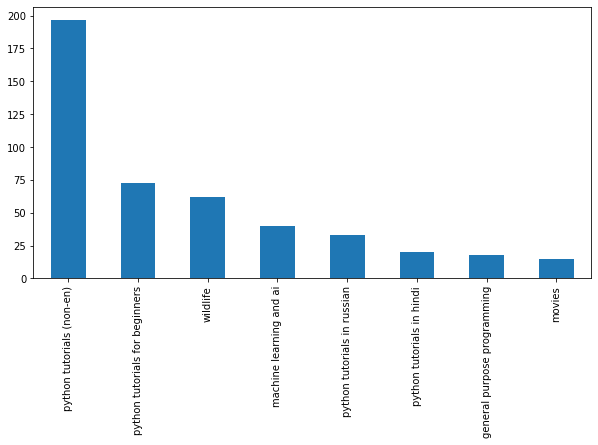

In [46]:
df['category'].value_counts().plot(kind='bar', figsize=(10,5))
plt.show()

### Observation
- Python can represent programming language, wildlife as well movies. Hence we should choose our keywords carefully to keep video on top.
- non-english videos are quite common in the youtube search for programming videos

In [47]:
likes_df = pd.DataFrame(df.groupby('category')['likeCount'].sum().sort_values(ascending=False))

In [48]:
comments_df = pd.DataFrame(df.groupby('category')['commentCount'].sum().sort_values(ascending=False))

In [49]:
video_count_df = pd.DataFrame(df['category'].value_counts())
video_count_df.rename(columns={'category': 'video_count'}, inplace=True)

In [50]:
all_stats = likes_df.join(comments_df)
all_stats = all_stats.join(video_count_df)
all_stats = all_stats.join(category_vs_duration_df)

In [51]:
all_stats

,likeCount,commentCount,video_count,duration,avg_duration
category,,,,,
python tutorials for beginners,3250544,164805,73,4 days 23:13:41,0 days 01:37:59.739726027
python tutorials (non-en),3137884,136299,197,6 days 07:49:27,0 days 00:46:14.451776649
wildlife,2350786,128350,62,0 days 09:17:49,0 days 00:08:59.822580645
python tutorials in hindi,804373,99926,20,2 days 03:56:35,0 days 02:35:49.750000
python tutorials in russian,710468,34717,33,0 days 23:22:28,0 days 00:42:29.939393939
machine learning and ai,363527,13859,40,2 days 10:26:33,0 days 01:27:39.825000
movies,311867,10785,15,0 days 09:24:00,0 days 00:37:36
general purpose programming,265861,14455,18,1 days 02:24:26,0 days 01:28:01.444444444


In [52]:
all_stats['like_engagement'] = all_stats['likeCount']/all_stats['video_count']
all_stats['comment_engagement'] = all_stats['commentCount']/all_stats['video_count']

In [53]:
all_stats

,likeCount,commentCount,video_count,duration,avg_duration,like_engagement,comment_engagement
category,,,,,,,
python tutorials for beginners,3250544,164805,73,4 days 23:13:41,0 days 01:37:59.739726027,44528.000000,2257.602740
python tutorials (non-en),3137884,136299,197,6 days 07:49:27,0 days 00:46:14.451776649,15928.345178,691.873096
wildlife,2350786,128350,62,0 days 09:17:49,0 days 00:08:59.822580645,37915.903226,2070.161290
python tutorials in hindi,804373,99926,20,2 days 03:56:35,0 days 02:35:49.750000,40218.650000,4996.300000
python tutorials in russian,710468,34717,33,0 days 23:22:28,0 days 00:42:29.939393939,21529.333333,1052.030303
machine learning and ai,363527,13859,40,2 days 10:26:33,0 days 01:27:39.825000,9088.175000,346.475000
movies,311867,10785,15,0 days 09:24:00,0 days 00:37:36,20791.133333,719.000000
general purpose programming,265861,14455,18,1 days 02:24:26,0 days 01:28:01.444444444,14770.055556,803.055556


In [54]:
all_stats.to_csv("all_category_stats.csv", index_label=["category"])

### Observation
- The most common videos are tutorials for beginners. This can be explained by the fact that initially a lot of people come on youtube to learn about the basics of a language (even those who have prior programming experience). If we want to stand out in this segment, we need to produce high quality videos consistently.

- Another good approach could be to pick a niche such as "machine learning" as the payout is probably higher from youtube for such a topic.

- We also observe that the engagement for hindi tutorials is quite high, which should be an easy audience for us to target since we already know the language.

---